In [1]:
import sys
sys.path.insert(0, 'backend_functions')
from scipy.stats import norm
from matplotlib.colors import LogNorm
import xsec_functions

import importlib
import uproot
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

importlib.reload(xsec_functions)
from xsec_functions import *

import selection_functions
import awkward

import ROOT

from ROOT import TH2D, TH1D, TH1F

import top 
from top import *

Welcome to JupyROOT 6.18/00


In [2]:
importlib.reload(selection_functions)
from selection_functions import *

In [3]:
fhc_data_pot = parameters(ISRUN3=False)['beamon_pot']
rhc_data_pot = parameters(ISRUN3=True)['beamon_pot']

In [4]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

fhc_nue = uproot.open(parameters(ISRUN3=False)['full_ntuple_path']+parameters(ISRUN3=False)['NUE']+".root")[fold][tree]
rhc_nue = uproot.open(parameters(ISRUN3=True)['full_ntuple_path']+parameters(ISRUN3=True)['NUE']+".root")[fold][tree]

uproot_nue = [fhc_nue, rhc_nue]
              

In [5]:
variables = [
    "selected", "nu_pdg", 
    "trk_score_v", 
    "shr_tkfit_dedx_Y",
    "ccnc", 
    "n_tracks_contained", 
    "NeutrinoEnergy2",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "true_nu_vtx_x", "true_nu_vtx_y" , "true_nu_vtx_z", 
    "nproton", "nu_e", "n_showers_contained",
    "shr_score", 
    "trk_energy", "tksh_distance", "tksh_angle",
    "npi0", 
    "shr_energy_tot_cali", "shr_energy_cali", 
    "nslice",
    "contained_fraction",
    "npion", "run", 
    "shrmoliereavg", 
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", 
    "shr_tkfit_npointsvalid","shr_tkfit_npoints", "true_e_visible", "trkshrhitdist2", 
    "weightSplineTimesTune", "weightTune", "true_nu_px", "true_nu_py", "true_nu_pz", 
    "elec_e", "proton_e", "mc_px", "mc_py", "mc_pz", "elec_px", "elec_py", "elec_pz", 
    "swtrig_pre", "ppfx_cv", "mc_pdg", 'opening_angle']

In [6]:
fhc_nue = fhc_nue.pandas.df(variables, flatten=False)

In [7]:
rhc_nue = rhc_nue.pandas.df(variables, flatten=False)

In [8]:
fhc_nue = addAngles(fhc_nue)
rhc_nue = addAngles(rhc_nue)

In [9]:

df_v = [fhc_nue, rhc_nue]
    
for i,df in enumerate(df_v):
    up = uproot_nue[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['NeutrinoEnergy2_GeV'] = df['NeutrinoEnergy2']/1000
    df['is_signal'] = np.where((df.swtrig_pre == 1) 
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                             & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    

In [10]:
# all we care about is signal 

fhc_signal = fhc_nue.query('swtrig_pre==1 and is_signal==True')
rhc_signal = rhc_nue.query('swtrig_pre==1 and is_signal==True')

df_v = [fhc_signal, rhc_signal]

In [11]:
# cuts applied for bad weights 

for i,df in enumerate(df_v):

    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.  
    
    df['totweight_intrinsic'] = df['ppfx_cv']*df['weightSplineTimesTune']
    

/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [12]:
fhc_signal = pot_scale(fhc_signal, 'intrinsic', False)
rhc_signal = pot_scale(rhc_signal, 'intrinsic', True)

Adding pot_scale column using dirt & EXT tune....
Adding pot_scale column using dirt & EXT tune....


In [13]:
fhc_signal['totweight_data'] = fhc_signal['ppfx_cv']*fhc_signal['weightSplineTimesTune']*fhc_signal['pot_scale']
rhc_signal['totweight_data'] = rhc_signal['ppfx_cv']*rhc_signal['weightSplineTimesTune']*rhc_signal['pot_scale']

### apply bdt model

In [14]:
fhc_signal = fhc_signal.query(BDT_LOOSE_CUTS)
rhc_signal = rhc_signal.query(BDT_LOOSE_CUTS)

In [15]:
print(parameters(ISRUN3=False)['bdt_score_cut'])
print(parameters(ISRUN3=True)['bdt_score_cut'])

0.55
0.575


In [16]:
# FHC FIRST

bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model(parameters(ISRUN3=False)['bdt_model'])

# clean datasets 
for column in training_parameters:
    fhc_signal.loc[(fhc_signal[column] < -1.0e37) | (fhc_signal[column] > 1.0e37), column] = np.nan
    
# create testing dmatrix 
fhc_signal_test = xgb.DMatrix(data=fhc_signal[training_parameters])
    
# apply the bdt selection
preds = bdt_model.predict(fhc_signal_test)

# add columns for plotting 
fhc_signal['BDT_score'] = preds

In [17]:
np.sum(fhc_signal.query(BDT_LOOSE_CUTS+' and BDT_score>'+str(parameters(ISRUN3=False)['bdt_score_cut'])).totweight_data)

59.45244421334784

In [18]:
# NOW DO RHC 

bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model(parameters(ISRUN3=False)['bdt_model'])

# clean datasets 
for column in training_parameters:
    rhc_signal.loc[(rhc_signal[column] < -1.0e37) | (rhc_signal[column] > 1.0e37), column] = np.nan
    
# create testing dmatrix 
rhc_signal_test = xgb.DMatrix(data=rhc_signal[training_parameters])
    
# apply the bdt selection
preds = bdt_model.predict(rhc_signal_test)

# add columns for plotting 
rhc_signal['BDT_score'] = preds

sum(rhc_signal.query(BDT_LOOSE_CUTS+' and BDT_score>'+str(parameters(ISRUN3=True)['bdt_score_cut'])).totweight_data)

100.41680902736584

### Play with binning

In [19]:
fhc_selected_signal = fhc_signal.query(BDT_LOOSE_CUTS+' and BDT_score>'+str(parameters(ISRUN3=False)['bdt_score_cut']))
rhc_selected_signal = rhc_signal.query(BDT_LOOSE_CUTS+' and BDT_score>'+str(parameters(ISRUN3=True)['bdt_score_cut']))

In [20]:
importlib.reload(xsec_functions)
from xsec_functions import *

In [21]:
xvar = 'NeutrinoEnergy2_GeV'
true_var = 'true_e_visible'

normalizing to POT 2e+20


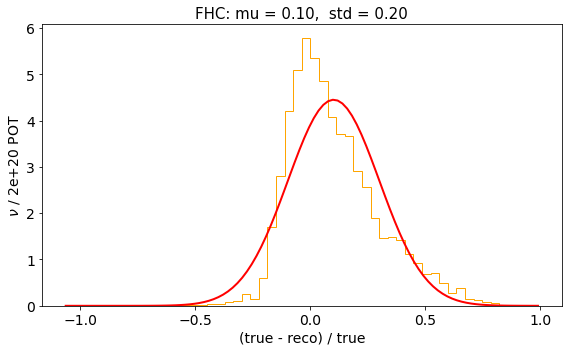

normalizing to POT 5.014e+20


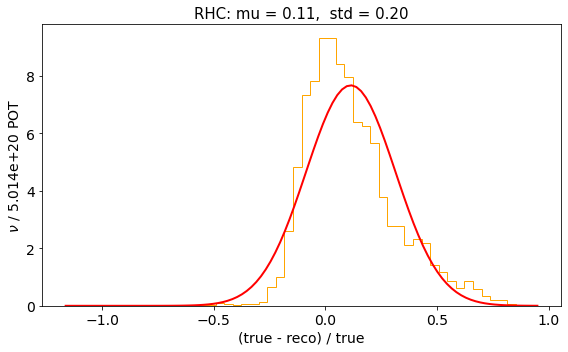

In [22]:
## detector resolution 

# fhc 
true_reco_res(true_var, xvar, fhc_selected_signal, ISRUN3=False, ymax=None, save=False)

# rhc 
true_reco_res(true_var, xvar, rhc_selected_signal, ISRUN3=True, ymax=None, save=False)


In [ ]:
#shower energy
#[0.07, 0.26, 0.45, 0.64, 0.83, 1.02, 1.4, 4.60] # update to even out the last bin (go as far as truth level?)

# visible energy 
#bins = [0.09, 0.36, 0.56, 0.76, 0.96, 1.16, 1.36, 1.65, 2.25, 6.5]

# tksh_angle



In [ ]:
# min & max reco/truth values 

bins = [-1, np.cos(3*np.pi/4), np.cos(5*np.pi/8), 0, np.cos(3*np.pi/8), np.cos(np.pi/4), 1]

fig = plt.figure(figsize=(8, 5))



x = plt.hist([fhc_selected_signal[xvar], rhc_selected_signal[xvar]], bins, color=['orange', 'peru'], 
         weights=[fhc_selected_signal['totweight_data'], rhc_selected_signal['totweight_data']], 
                  label=['FHC ($2\\times10^{20}$ POT)', 'RHC ($5\\times10^{20}$ POT)'], stacked=True)

plt.legend(fontsize=14, loc='upper left')
#plt.title("FHC RUN 1 ("+str(fhc_data_pot)+' POT)', fontsize=15)

plt.xlabel("$cos$ $\\theta_{ep}$", fontsize=15)
plt.ylabel("Signal event rate", fontsize=15)

plt.xticks(bins)
plt.ylim(0, 50)

plt.show()

In [ ]:
[-1, -0.5, np.cos(95*np.pi/180), np.cos(85*np.pi/180), 0.5, 1]

In [ ]:
# min & max reco/truth values 

bins = [-1, -0.5, np.cos(95*np.pi/180), np.cos(85*np.pi/180), 0.5, 1]

fig = plt.figure(figsize=(8, 5))



x = plt.hist([fhc_selected_signal[xvar], rhc_selected_signal[xvar]], bins, color=['orange', 'peru'], 
         weights=[fhc_selected_signal['totweight_data'], rhc_selected_signal['totweight_data']], 
                  label=['FHC ($2\\times10^{20}$ POT)', 'RHC ($5\\times10^{20}$ POT)'], stacked=True)

plt.legend(fontsize=14, loc='upper left')
#plt.title("FHC RUN 1 ("+str(fhc_data_pot)+' POT)', fontsize=15)

plt.xlabel("$cos$ $\\theta_{ep}$", fontsize=15)
plt.ylabel("Signal event rate", fontsize=15)

plt.xticks(bins)
plt.ylim(0, 50)

plt.show()

In [ ]:
# min & max reco/truth values 

#bins = [-1, -0.7, -0.42, -0.14, 0.14, 0.42, 0.7, 1]
bins = [-1, -0.5, np.cos(100 * np.pi/180), np.cos(80 * np.pi/180), 0.5, 1]

fig = plt.figure(figsize=(8, 5))



x = plt.hist([fhc_selected_signal[xvar], rhc_selected_signal[xvar]], bins, color=['orange', 'peru'], 
         weights=[fhc_selected_signal['totweight_data'], rhc_selected_signal['totweight_data']], 
                  label=['FHC ($2\\times10^{20}$ POT)', 'RHC ($5\\times10^{20}$ POT)'], stacked=True)

plt.legend(fontsize=14, loc='upper left')
#plt.title("FHC RUN 1 ("+str(fhc_data_pot)+' POT)', fontsize=15)

plt.xlabel("$cos$ $\\theta_{ep}$", fontsize=15)
plt.ylabel("Signal event rate", fontsize=15)

plt.xticks(bins)
plt.ylim(0, 50)

plt.show()



In [ ]:
bins

In [ ]:
xvar='NeutrinoEnergy2_GeV'
#bins = [0.05, 0.45, 0.65, 0.85, 1.05, 1.25, 1.65, 2.25, 7]
bins = [0.05, 0.45, 0.65, 0.85, 1.05, 1.35, 1.85, 7]

fig = plt.figure(figsize=(8, 5))

fhc_reco = plt.hist(fhc_selected_signal[xvar], bins, color='orange', 
         weights=fhc_selected_signal['totweight_data'], label='reco FHC')[0]

#fhc_true = plt.hist(fhc_selected_signal[true_var], bins, 
#         weights=fhc_selected_signal['totweight_data'], 
#         color='saddlebrown', label='true FHC', histtype='step', linewidth=2, linestyle='--')[0]

plt.legend(fontsize=14)


#plt.xlabel("$cos$ $\\theta_{ep}$", fontsize=15)
plt.ylabel("Signal event rate", fontsize=15)
#plt.xticks(bins)

plt.show()

fig = plt.figure(figsize=(8, 5))

rhc_reco = plt.hist(rhc_selected_signal[xvar], bins, color='orange', 
         weights=rhc_selected_signal['totweight_data'], label='reco RHC')[0]

#rhc_true = plt.hist(rhc_selected_signal[true_var], bins, 
#         weights=rhc_selected_signal['totweight_data'], 
#         color='saddlebrown', label='true RHC', histtype='step', linewidth=2, linestyle='--')[0]

plt.legend(fontsize=14)

#plt.xlabel("$cos$ $\\theta_{ep}$", fontsize=15)
plt.ylabel("Signal event rate", fontsize=15)
#plt.xticks(bins)


plt.show()

fhc_reco+rhc_reco

In [ ]:
rhc_reco



In [ ]:
## smearing matrix 
fig = plt.figure(figsize=(11, 8))

hout = plt.hist2d(fhc_selected_signal[true_var], fhc_selected_signal[xvar], [0.07, 0.26, 0.45, 0.64, 0.83, 1.02, 1.4, 4.5], 
                              weights=fhc_selected_signal.totweight_data, cmap='OrRd', cmin=0.01)

smear_array = hout[0].T

for i in range(len(bins)-1): # reco bins i (y axis)
        for j in range(len(bins)-1): # true bins j (x axis)
            if smear_array[i][j]>7: 
                col='white'
            else: 
                col='black'

            binx_centers = hout[1][j]+(hout[1][j+1]-hout[1][j])/2
            biny_centers = hout[2][i]+(hout[2][i+1]-hout[2][i])/2

            if not np.isnan(smear_array[i][j]):
                plt.text(binx_centers, biny_centers, round(smear_array[i][j], 1), 
                            color=col, ha="center", va="center", fontsize=12)
                
                
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

cbar = plt.colorbar()
#cbar.set_label('$\\nu$ / '+pot+' POT', fontsize=15)

plt.xlabel('True Electron Energy [GeV]', fontsize=15)
plt.ylabel('Reco Electron Energy [GeV]', fontsize=15)

#plt.title(title+' - Smearing '+str(parameters(isrun3)['beamon_pot'])+' POT', fontsize=15)

cbar.ax.tick_params(labelsize=14)
plt.show()


In [ ]:
print('min reco', min(fhc_selected_signal[xvar]))
print('max reco', max(fhc_selected_signal[xvar]))

print('min true', min(fhc_selected_signal[true_var]))
print('max true', max(fhc_selected_signal[true_var]))

In [ ]:

print('min reco', min(rhc_selected_signal[xvar]))
print('max reco', max(rhc_selected_signal[xvar]))

print('min true', min(rhc_selected_signal[true_var]))
print('max true', max(rhc_selected_signal[true_var]))


## resolution plots

In [182]:
xvar = 'tksh_angle'
true_var = 'opening_angle'

bins = [-1, -0.5, np.cos(100 * np.pi/180), np.cos(80 * np.pi/180), 0.5, 1]
x_ticks = [-1, -0.5, -0.174, 0.174, 0.5, 1]


xlow = bins[0]
xhigh = bins[-1]

x_label = "cos $\\theta_{ep}$"

In [183]:
fhc_selected_signal = fhc_signal.query(BDT_LOOSE_CUTS+' and BDT_score>'+str(parameters(ISRUN3=False)['bdt_score_cut']))
rhc_selected_signal = rhc_signal.query(BDT_LOOSE_CUTS+' and BDT_score>'+str(parameters(ISRUN3=True)['bdt_score_cut']))

In [184]:
if xvar == 'tksh_angle': 
    fhc_selected_signal['res'] = (fhc_selected_signal[true_var]-fhc_selected_signal[xvar])
    rhc_selected_signal['res'] = (rhc_selected_signal[true_var]-rhc_selected_signal[xvar])
    
else: 
    fhc_selected_signal['res'] = (fhc_selected_signal[true_var]-fhc_selected_signal[xvar])/fhc_selected_signal[true_var]
    rhc_selected_signal['res'] = (rhc_selected_signal[true_var]-rhc_selected_signal[xvar])/rhc_selected_signal[true_var]

/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [185]:
print(min(fhc_selected_signal[true_var]))
print(min(rhc_selected_signal[true_var]))

-0.9971619844436646
-0.9885615706443787


In [186]:
print(max(fhc_selected_signal[true_var]))
print(max(rhc_selected_signal[true_var]))

0.9994841814041138
0.9979190826416016


In [187]:
selected_signal = pd.concat([fhc_selected_signal, rhc_selected_signal], sort=False)

In [192]:
if xvar != 'tksh_angle': 
    bincenters = 0.5*(np.array(x_ticks+[xhigh])[1:]+np.array(x_ticks+[xhigh])[:-1])
    
else: 
    bincenters = 0.5*(np.array(x_ticks)[1:]+np.array(x_ticks)[:-1])


In [194]:
binwidth = []

for x in range(len(bincenters)):

    if xvar=='tksh_angle': 
        binwidth.append(round(abs((x_ticks)[x+1]-(x_ticks)[x])/2, 2))

    else: 
        binwidth.append(round(abs((bins[:-1]+[xhigh])[x+1]-(bins[:-1]+[xhigh])[x])/2, 3))

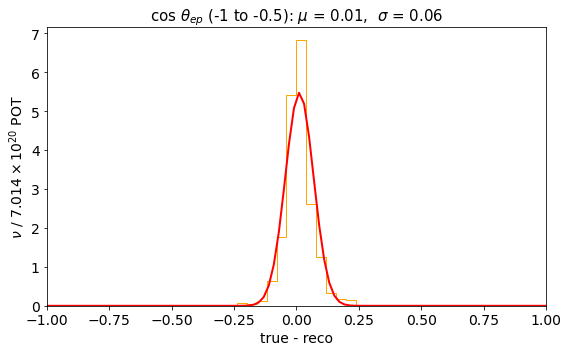

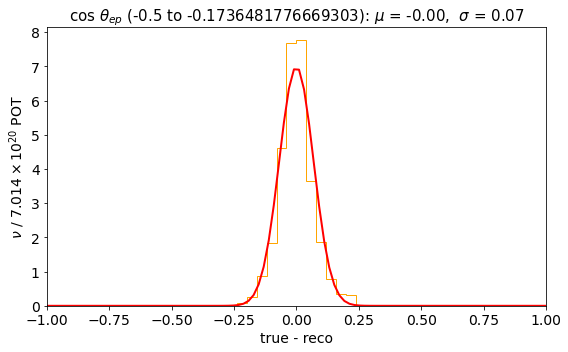

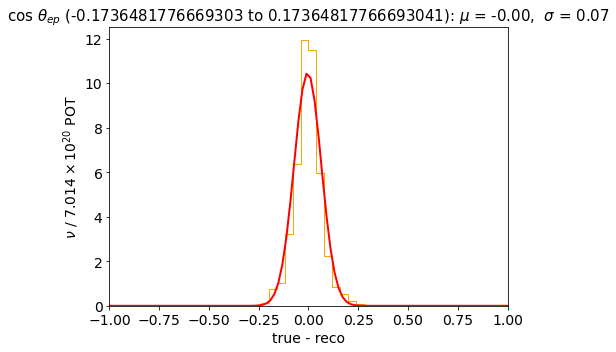

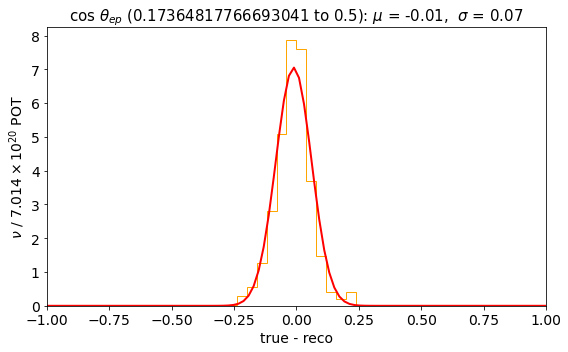

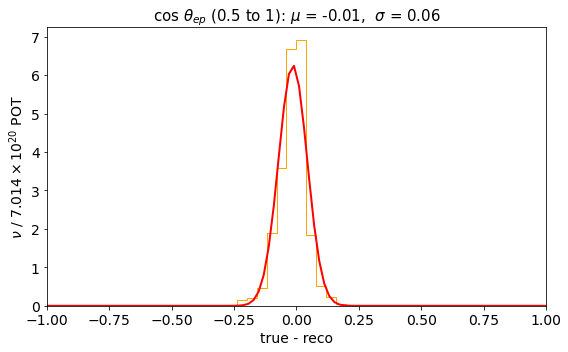

In [200]:
# for each bin, get the sigma of the resolution 

sigma_per_bin = []

for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])
        
    if xvar=='tksh_angle': 
        bin_query = bin_query + ' and res<0.25 and res>-0.25'

    mu, sigma = weighted_avg_and_std(selected_signal.query(bin_query).res, selected_signal.query(bin_query).totweight_data)
    sigma_per_bin.append(sigma)
    
    fig = plt.figure(figsize=(8, 5))
    n, b, p = plt.hist(selected_signal.query(bin_query).res, 50, range=[-1, 1], histtype='step', 
                       weights=selected_signal.query(bin_query).totweight_data, color='orange')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.xlim(-1, 1)
    
    if xvar == 'tksh_angle': 
        plt.xlabel('true - reco', fontsize=14)
    
    else: 
        plt.xlabel('(true - reco) / true', fontsize=14)
    plt.ylabel('$\\nu$ / $7.014 \\times 10^{20}$ POT', fontsize=14)
    
    # PLOT THE PDF
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)
    area = np.sum(np.diff(b)*n)
    
    plt.plot(x, p*area, 'k', linewidth=2, color='red')
    
    plt.title(x_label+" ("+str(bins[i])+" to "+ str(bins[i+1])+"): $\\mu$ = %.2f,  $\\sigma$ = %.2f" % (mu, sigma), fontsize=15)
    
    plt.tight_layout()
    plt.show()
    
    bin_query = ''
    

In [179]:
sigma_per_bin

[0.23678708551689806,
 0.19943902548200124,
 0.23099655001213368,
 0.15788204083105617,
 0.14790797590768856,
 0.1326882860636025]

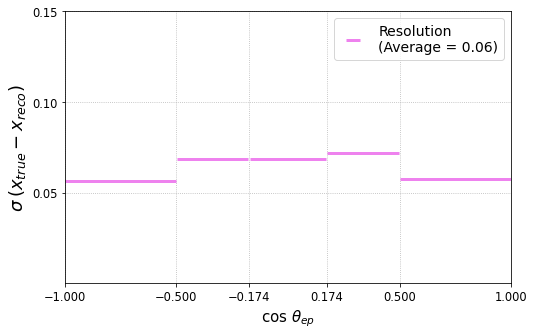

In [202]:
# plot resolution vs. true 

fig = plt.figure(figsize=(8, 5))

plt.errorbar(bincenters, sigma_per_bin, fmt='.', color='violet', xerr=binwidth, markersize=1, 
             label="Resolution\n(Average = %.2f)" % np.average(sigma_per_bin), 
            linewidth=3)

#plt.axhline(np.average(sigma_per_bin), color='black', linestyle="--", label="Average = %.2f" % np.average(sigma_per_bin))

plt.xlim(xlow, xhigh)
plt.ylim(0, .15)

plt.xticks(x_ticks, fontsize=11.5)
plt.yticks([0.05, .1, .15], fontsize=11.5)

if xvar != 'tksh_angle': 
    plt.xlabel(x_label+" [GeV]", fontsize=15)
    plt.ylabel("$\\sigma \: (\\frac{x_{true} - x_{reco}}{x_{true}})$", fontsize=18)
    
else: 
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel("$\\sigma \: (x_{true} - x_{reco})$", fontsize=18)

plt.grid(linestyle=":")

plt.legend(fontsize=14)

plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/resolution_"+xvar+".pdf", 
            transparent=True, bbox_inches='tight')

plt.show()

0.18168534598965172